In [1]:
# Import dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import datetime as dt

import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, desc
from sqlalchemy.sql import label

In [2]:
# Database setup
engine = create_engine("sqlite:///hawaii.sqlite")
# Reflect an existing database into a new model
Base = automap_base()
# Reflect the tables
Base.prepare(engine, reflect=True)

# Save reference to the tables
Measurements = Base.classes.measurements
Station = Base.classes.station

# Create our session (link) from Python to the DB
session = Session(bind = engine)

In [3]:
# Get table names for all tables
inspector = inspect(engine)
inspector.get_table_names()

['measurements', 'station']

In [4]:
# Get a list of column names and types - for measurements table
columns = inspector.get_columns('measurements')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [5]:
engine.execute('SELECT * FROM measurements LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-07', 0.06, 70.0)]

In [6]:
# Get a list of column names and types - for station table
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [7]:
engine.execute('SELECT * FROM station LIMIT 5').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

In [8]:
#-----Precipitation Analysis-----
# Query to retrieve the last 12 months of precipitation data
yearly_results = session.query(Measurements.date, Measurements.prcp).filter(Measurements.date >= '2016-08-23')

In [9]:
# create empty dict to populate
data_dict = {'date': [], 'precipitation': []}

# populate dict with rows from results
for row in yearly_results:
    data_dict['precipitation'].append(row.prcp)
    data_dict['date'].append(row.date)

# create pandas df from dict
precipitation_df = pd.DataFrame(data_dict['precipitation'], columns = ['prcp'], index = data_dict['date'])
print(precipitation_df.head())

            prcp
2016-08-23  0.00
2016-08-24  0.08
2016-08-25  0.08
2016-08-26  0.00
2016-08-27  0.00


Precipitation Analysis


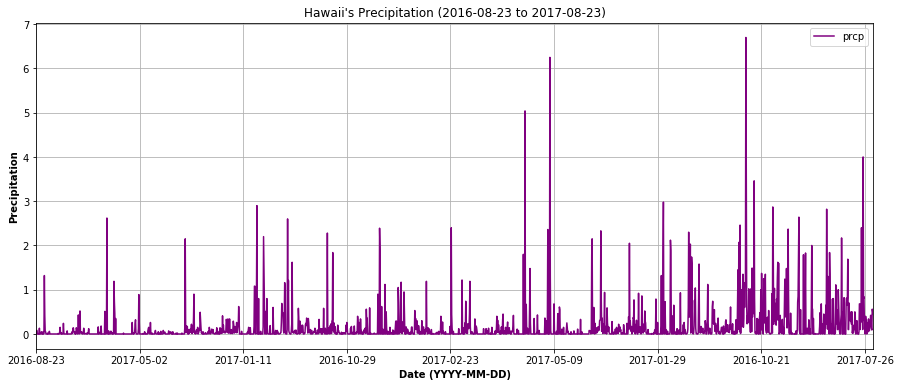

In [10]:
print('Precipitation Analysis')
#plot the data
prcp_plot = precipitation_df.plot(figsize = (15, 6), sort_columns=True, legend=True, use_index=True, grid=True, color='purple')
plt.xlabel('Date (YYYY-MM-DD)', weight='bold')
plt.ylabel('Precipitation', weight='bold')
plt.title("Hawaii's Precipitation (2016-08-23 to 2017-08-23)")
plt.show()

In [11]:
#Use Pandas to print the summary statistics for the precipitation data
precipitation_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [12]:
#Station Analysis
# Design a query to calculate the total number of stations.
station_analysis = session.query(Station.id).count()
print("There are '%s' stations."%(station_analysis))

There are '9' stations.


In [13]:
#Design a query to find the most active stations.
#List the stations and observation counts in descending order
ma_stations = session.query(Measurements.station,func.count(Measurements.tobs),Station.name).filter(Measurements.station == Station.station).group_by(Measurements.station).order_by(func.count(Measurements.tobs).desc()).all()
ma_stations

[('USC00519281', 2772, 'WAIHEE 837.5, HI US'),
 ('USC00513117', 2696, 'KANEOHE 838.1, HI US'),
 ('USC00519397', 2685, 'WAIKIKI 717.2, HI US'),
 ('USC00519523', 2572, 'WAIMANALO EXPERIMENTAL FARM, HI US'),
 ('USC00516128', 2484, 'MANOA LYON ARBO 785.2, HI US'),
 ('USC00514830', 1937, 'KUALOA RANCH HEADQUARTERS 886.9, HI US'),
 ('USC00511918', 1932, 'HONOLULU OBSERVATORY 702.2, HI US'),
 ('USC00517948', 683, 'PEARL CITY, HI US'),
 ('USC00518838', 342, 'UPPER WAHIAWA 874.3, HI US')]

In [14]:
#Which station has the highest number of observations?
#Note. WAIHEE has the highest number of observations 2772
highest_observations = session.query(Measurements.station,func.count(Measurements.tobs),Station.name).filter(Measurements.station == Station.station).group_by(Measurements.station).order_by(func.count(Measurements.tobs).desc()).first()
print(highest_observations)

('USC00519281', 2772, 'WAIHEE 837.5, HI US')


In [15]:
#Design a query to retrieve the last 12 months of temperature observation data (tobs).
yearly_tobs = session.query(Measurements.tobs).filter(Measurements.station == highest_observations[0], Measurements.station == Station.station, Measurements.date >="2016-08-23", Measurements.date <="2017-08-23").all()

#List the temperatures
waihee_temperature = [temperature[0] for temperature in yearly_tobs]

-----Station Analysis-----


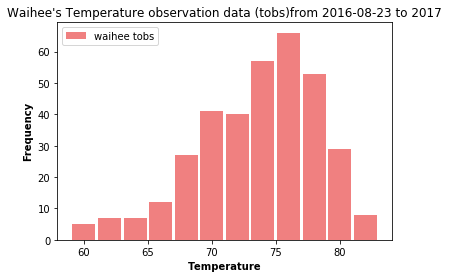

In [38]:
print('-----Station Analysis-----')
#Plot the results as a histogram with bins=12.
plt.hist(waihee_temperature, color='lightcoral', bins=12, rwidth = 0.9)
plt.xlabel('Temperature', weight='bold')
plt.ylabel('Frequency', weight='bold')
plt.title("Waihee's Temperature observation data (tobs)from 2016-08-23 to 2017")
labels = ['waihee tobs']
plt.legend(labels)
plt.show()

In [45]:
#Temperature Analysis
#Write a function called calc_temps that will accept a start date and end date in the format %Y-%m-%d and return the minimum, average, and maximum temperatures for that range of dates.
def calc_temps(startdate,enddate):
    temp_query = session.query(Measurements.tobs).filter(Measurements.date>=startdate, Measurements.date<=enddate).all()
    temperatures = [temperature[0] for temperature in temp_query]
    min_temperature = min(temperatures)
    max_temperature = max(temperatures)
    avg_temperature = np.mean(temperatures)
    
    #Plot the min, avg, and max temperature from your previous query as a bar chart.
    #Use the average temperature as the bar height.
    #Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr).
    plt.figure(figsize=(3,5))
    plt.bar(1, avg_temperature, yerr=(max_temperature - min_temperature), tick_label='', color='skyblue')
    plt.title("Trip Avg Temperature Plot", weight="bold")
    plt.ylabel("Temperature(F)", weight="bold")
    plt.show()

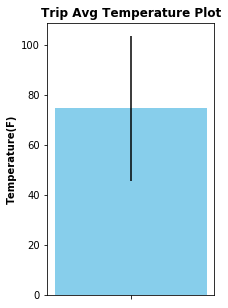

In [47]:
calc_temps(startdate="2016-08-23", enddate="2017-08-23")